In [1]:
import os
import cv2
import random
import numpy as np 
import pandas as pd 
import seaborn as sns

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# To plot pretty figures
%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt
!pip install yellowbrick
from yellowbrick.classifier import ROCAUC

## Data Loading 

This step loads the images contained in the training dataset.

In [2]:
labels = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
train_img = [] #contains the images used for training the model
train_labels = [] #label of each image in x_train 
PATH = 'archive/Training'

for label in labels:
    img_dir = os.path.join(PATH, label)
    for img_file in os.listdir(img_dir):
        img = cv2.imread(f'{img_dir}/{img_file}')
        train_img.append(img)
        train_labels.append(label)
        
new_size = (255, 255)

for i in range(len(train_img)):
    img = train_img[i] 
    train_img[i] = cv2.resize(img, new_size)
    train_img[i] = cv2.cvtColor(train_img[i], cv2.COLOR_RGB2GRAY)/255

train_img = np.stack(train_img)
train_labels = np.stack(train_labels)

print("train_img shape : ", train_img.shape)
print("train_labels shape : ", train_labels.shape)

class_map = {
    'no_tumor': 0,
    'glioma_tumor': 1,
    'pituitary_tumor': 2,
    'meningioma_tumor': 3
}

train_labels = np.array([class_map[label] for label in train_labels])

train_img shape :  (2870, 255, 255)
train_labels shape :  (2870,)


# Dimensionality reduction by PCA implementation

See lab3 for more details

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_img.reshape((train_img.shape[0], 255*255)), train_labels, test_size = 0.3, random_state = 42)

In [4]:
from sklearn.preprocessing import StandardScaler #the Standard Scaler : X2 = (X1 - E(X1))/sqrt(Var(X1))
from sklearn.decomposition import PCA


S = StandardScaler()
X_train = S.fit_transform(X_train)
X_test = S.transform(X_test)

## Classifier evaluation with different metrics

Many metrics are already computed by sklearn modules and methods. Here we propose to code some metrics from scratch, notably the binary confusion matrices, the F1-score, as well as K-fold cross-validation.

In [5]:
# Evaluation Buffers
# classifiers = ["NB", "KNN", "SVM"]
classifiers = ["Multinomial", "Gaussian", "Complement", "Bernoulli"]
PCA_comp = []
Acc = []
Pr = []
Rec = []
Spec= []
F1 = [] 
AUC = []

In [6]:
# Data to be exploited

n_comp = np.arange(2, 402, 20)
pca = PCA(n_components = 402)
pca_train = pca.fit_transform(X_train)
pca_test = pca.transform(X_test)

### Binary classification

From a confusion matrix, extract a binary one where i is the True Positive class represented by 1. The rest will be represented as 0.

In [7]:
from sklearn.metrics import confusion_matrix, classification_report #to provide confusion matrix with rows = True values and columns = Predicted values

def conf_bin(conf, i):
    row_i = np.sum(conf[i,:]) - conf[i,i]
    col_i = np.sum(conf[:,i]) - conf[i,i]
    rest = np.sum(conf)- row_i - col_i - conf[i,i]
    new_conf = np.array([[conf[i,i], row_i],
                        [col_i, rest]])
    return new_conf

### Multinomial Naive Bayes

MultinomialNB implements the naive Bayes algorithm for multinomially distributed data, and is one of the two classic naive Bayes variants used in text classification (where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice). The distribution is parametrized by vectors $\theta_y = \left(\theta_{y1},\dots,\theta_{yn}\right)$ for each class $y$, where $n$ is the number of features (in text classification, the size of the vocabulary) and $\theta_{yi}$ is the probability $P\left(x_i\mid y\right)$ of feature $i$ appearing in a sample belonging to class $y$.

The parameters $\theta_y$ is estimated by a smoothed version of maximum likelihood, i.e. relative frequency counting:

$$\hat{\theta_{yi}} = \frac{N_{yi} + \alpha}{N_y + \alpha n}$$

 
where $N_{yi} = \sum_{x\in T} x_i$ is the number of times feature $i$ appears in a sample of class $y$ in the training set $T$, and $N_y = \sum^{n}_{i=1}N_{yi}$ is the total count of all features for class $y$.

The smoothing priors $\alpha \ge 0$ accounts for features not present in the learning samples and prevents zero probabilities in further computations. Setting $\alpha = 1$ is called Laplace smoothing, while $\alpha < 1$ is called Lidstone smoothing.

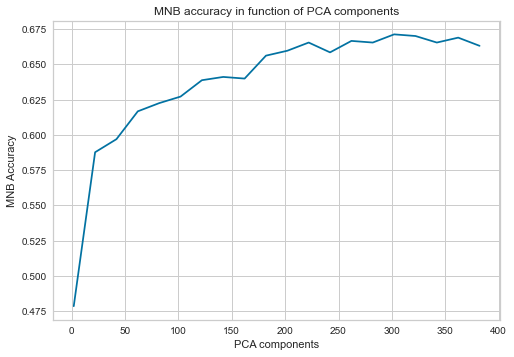

In [8]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

acc_MNB = []
for n in n_comp:
    
    MNB = MultinomialNB(alpha = 1.0, class_prior = [0.13, 0.29, 0.29, 0.29])
    #cf lab1
    
    scaler = MinMaxScaler() # normalizes data to the range 0 to 1 thus removing the negative numbers.
    Train = scaler.fit_transform(pca_train[:,:n])
    
    MNB.fit(Train, y_train)

    Test = scaler.transform(pca_test[:,:n])
    y_pred = MNB.predict(Test)


    cm1 = confusion_matrix(y_test, y_pred)
    acc1 = np.sum(np.diag(cm1))/np.sum(cm1)
    acc_MNB.append(acc1)

plt.figure()
plt.plot(n_comp, acc_MNB)
plt.xlabel('PCA components')
plt.ylabel('MNB Accuracy')
plt.title('MNB accuracy in function of PCA components')
plt.show()

In [9]:
# we choose 382 PCA components as it gives the best accuracy for Multinomial Naive Bayes

ind = acc_MNB.index(max(acc_MNB))
print(n_comp[ind])

MNB = MultinomialNB(alpha = 1.0, class_prior = [0.13, 0.29, 0.29, 0.29])

scaler = MinMaxScaler() # normalizes data to the range 0 to 1 thus removing the negative numbers.
Train = scaler.fit_transform(pca_train[:,:n_comp[ind]])
    
MNB.fit(Train, y_train)

Test = scaler.transform(pca_test[:,:n_comp[ind]])
y_pred = MNB.predict(Test)
    
conf_pred = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division =0)
rep2 = classification_report(y_test, y_pred, output_dict=True, zero_division = 0)
print(report)

acc = rep2['accuracy']
pr = rep2['weighted avg']['precision']
rec = rep2['weighted avg']['recall']
f1 = rep2['weighted avg']['f1-score']

# Weighted avg Specificity ?
p = [0.13, 0.29, 0.29, 0.29]
spec = 0
for i in range(4):
    conf_i = conf_bin(conf_pred, i)
    tp = conf_i[0,0]
    fn = conf_i[0,1]
    tn = conf_i[1,1]
    fp = conf_i[1,0]
    spec += p[i]*(tn/(tn + fp))
print("weighted specificity = ", spec)

302
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       114
           1       0.65      0.81      0.73       259
           2       0.75      0.91      0.83       236
           3       0.60      0.60      0.60       252

    accuracy                           0.67       861
   macro avg       0.50      0.58      0.54       861
weighted avg       0.58      0.67      0.62       861

weighted specificity =  0.8654712735326688


Average precision: 60%

The recall of the last class is extremly poor, which means the algorithm is very likely to categorise a class 3 input into another class.

NB :

$$precision = \frac{TP} {TP + FP}$$

$$recall = \frac{TP} {TP + FN}$$

$$F1 = 2 \frac{precision.recall} {precision + recall}$$

While accuracy simply informs of how often the classification is correct; F1 score informs how often a True Positive is indeed classified as True Positive (recall) as well as, if when a class is predicted, it is actually reliable (precision).

Here we notice a global accuracy somewhat superior to the average, however, F1 score for class 0 and class 3 are weak, which means that the classification concerning these classes are unreliable.

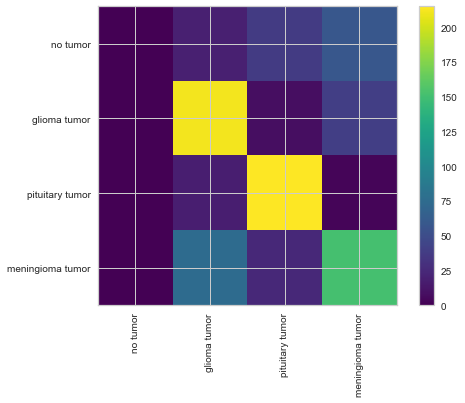

In [10]:
columns = ['no tumor', 'glioma tumor', 'pituitary tumor', 'meningioma tumor']

plt.figure()
plt.xticks(range(len(columns)),columns,rotation=90)
plt.yticks(range(len(columns)),columns)
im = plt.imshow(conf_pred, cmap='viridis',interpolation="nearest")
plt.colorbar(im)

plt.show(im)

In [11]:
# ROC analysis

def plot_ROC_curve(model, xtrain, ytrain, xtest, ytest):

    # Creating visualization with the readable labels
    visualizer = ROCAUC(model, encoder={0: 'no_tumor', 
                                        1: 'glioma', 
                                        2: 'pituitary',
                                        3: 'meningioma'})
                                        
    # Fitting to the training data first then scoring with the test data                                    
    visualizer.fit(xtrain, ytrain)
    visualizer.score(xtest, ytest)
    visualizer.show()
    
    return visualizer

def OH(y):
    n = y.size
    nb_class = y.max()+1
    new_y = np.zeros((n, nb_class))
    for i in range(n):
        new_y[i, y[i]] = 1
    return new_y

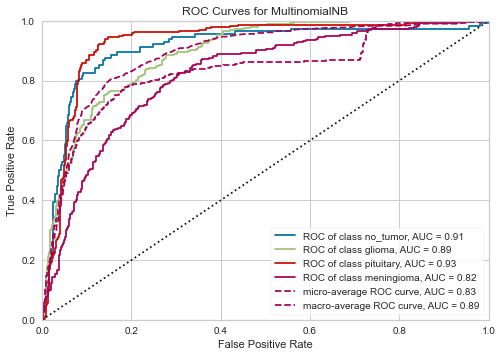

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for MultinomialNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={0: 'no_tumor', 1: 'glioma', 2: 'pituitary', 3: 'meningioma'},
       estimator=MultinomialNB(class_prior=[0.13, 0.29, 0.29, 0.29]))

In [12]:
plot_ROC_curve(MNB, Train, y_train, Test, y_test)

We have nearly the same results as without cross-validation. We can also clearly observe the lack of recall for the class 3

In [13]:
# updating buffer
PCA_comp.append(n_comp[ind])
Acc.append(acc)
Pr.append(pr)
Rec.append(rec)
Spec.append(spec)
F1.append(f1)
AUC.append(0.83)

### Gaussian Naive Bayes

A Machine Learning algorithm considering data features to be mutually independant and using a gaussian distribution to compute likelihood. Considering Bayes formula, we have :

$P(C_{k}|x) = \frac{P(x|C_{k}) P(C_{k})}{P(x)}$ with $C_{k}$ the k-th class and $x$ an n-feature vector

Using mutual independancy of features, we obtain :


$$P(C_{k}|x)  \propto P(C_{k})\prod \limits_{i=1}^{n} P(x_{i}| C_{k})$$

Therefore the classifier chooses the optimal class $\hat{y}$ by :

$$\hat{y} = \underset{k}{argmax} \Bigg \{P(C_{k})\prod \limits_{i=1}^{n} P(x_{i}| C_{k})\Bigg\} $$

Considering a Gaussian distribution, we have :


$$P(x_{i}=z |C_{k}) = \frac{1}{\sqrt{2 \pi \sigma_{k}^{2}}} \exp{\bigg(-\frac{(z - \mu_{k})^{2}}{2 \sigma_{k}^{2}}\bigg)}$$

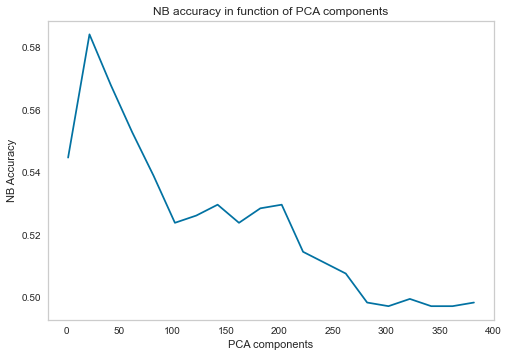

In [14]:
from sklearn.naive_bayes import GaussianNB

acc_NB = []
for n in n_comp:
    NB = GaussianNB()

    NB.fit(pca_train[:,:n], y_train)

    y_pred = NB.predict(pca_test[:,:n])

    cm1 = confusion_matrix(y_test, y_pred)
    acc1 = np.sum(np.diag(cm1))/np.sum(cm1)
    acc_NB.append(acc1)

plt.figure()
plt.plot(n_comp, acc_NB)
plt.grid()
plt.xlabel('PCA components')
plt.ylabel('NB Accuracy')
plt.title('NB accuracy in function of PCA components')
plt.show()

In [15]:
# we choose 20 PCA components as it gives the best accuracy for Naive Bayes

ind = acc_NB.index(max(acc_NB))
print(n_comp[ind])

gb = GaussianNB(priors = [0.13, 0.29, 0.29, 0.29])

scaler = MinMaxScaler() # normalizes data to the range 0 to 1 thus removing the negative numbers.
Train = scaler.fit_transform(pca_train[:,:n_comp[ind]])
    
gb.fit(Train, y_train)

Test = scaler.transform(pca_test[:,:n_comp[ind]])
y_pred = gb.predict(Test)
    
conf_pred = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division =0)
rep2 = classification_report(y_test, y_pred, output_dict=True, zero_division = 0)
print(report)

acc = rep2['accuracy']
pr = rep2['weighted avg']['precision']
rec = rep2['weighted avg']['recall']
f1 = rep2['weighted avg']['f1-score']

# Weighted avg Specificity ?
p = [0.13, 0.29, 0.29, 0.29]
spec = 0
for i in range(4):
    conf_i = conf_bin(conf_pred, i)
    tp = conf_i[0,0]
    fn = conf_i[0,1]
    tn = conf_i[1,1]
    fp = conf_i[1,0]
    spec += p[i]*(tn/(tn + fp))
print("weighted specificity = ", spec)

22
              precision    recall  f1-score   support

           0       0.50      0.44      0.47       114
           1       0.52      0.87      0.65       259
           2       0.78      0.75      0.76       236
           3       0.52      0.21      0.30       252

    accuracy                           0.59       861
   macro avg       0.58      0.57      0.55       861
weighted avg       0.59      0.59      0.56       861

weighted specificity =  0.8455171232349108


Average precision: 55.5%

The recall for class 3 is getting better but is still poor.

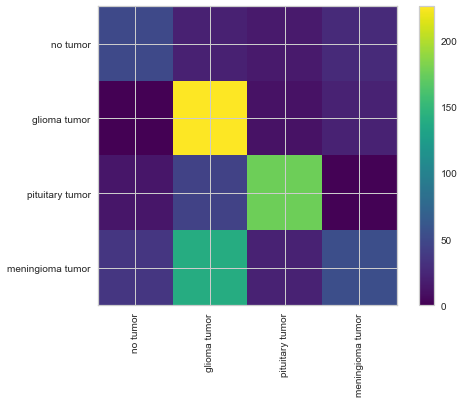

In [16]:
columns = ['no tumor', 'glioma tumor', 'pituitary tumor', 'meningioma tumor']

plt.xticks(range(len(columns)),columns,rotation=90)
plt.yticks(range(len(columns)),columns)
im = plt.imshow(conf_pred, cmap='viridis',interpolation="nearest")
plt.colorbar(im)

plt.show(im)

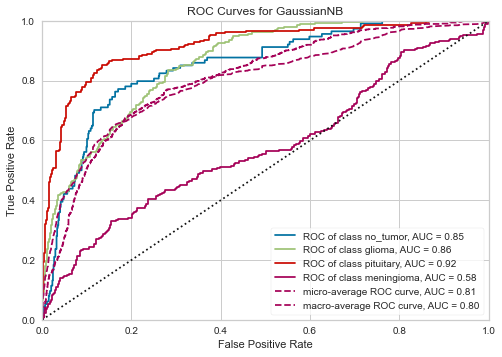

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for GaussianNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={0: 'no_tumor', 1: 'glioma', 2: 'pituitary', 3: 'meningioma'},
       estimator=GaussianNB(priors=[0.13, 0.29, 0.29, 0.29]))

In [17]:
# ROC curve

plot_ROC_curve(gb, Train, y_train, Test, y_test)

In [18]:
# updating buffer
PCA_comp.append(n_comp[ind])
Acc.append(acc)
Pr.append(pr)
Rec.append(rec)
Spec.append(spec)
F1.append(f1)
AUC.append(0.81)

### Complement Naive Bayes

ComplementNB implements the complement naive Bayes (CNB) algorithm. CNB is an adaptation of the standard multinomial naive Bayes (MNB) algorithm that is particularly suited for imbalanced data sets. Specifically, CNB uses statistics from the complement of each class to compute the model’s weights. The inventors of CNB show empirically that the parameter estimates for CNB are more stable than those for MNB. Further, CNB regularly outperforms MNB (often by a considerable margin) on text classification tasks. The procedure for calculating the weights is as follows:

$$\hat{\theta}_{ci} = \frac{\alpha_i + \sum_{j:y_j\ne c} d_{ij}}{\alpha + \sum_{j:y_j\ne c}\sum_k d_{kj}}$$

$$w_{ci}=\log\left(\hat{\theta}_{ci}\right)$$

$$w_{ci} = \frac{w_{ci}}{\sum_j \left|w_{cj}\right|}$$

where the summations are over all documents $j$ not in class $c$, $d_{ij}$ is either the count or tf-idf value of term $i$ in document $j$, $\alpha_i$ is a smoothing hyperparameter like that found in MNB, and $\alpha = \sum_i \alpha_i$. The second normalization addresses the tendency for longer documents to dominate parameter estimates in MNB. The classification rule is:

$$\hat{c} = \arg\min_{c}\sum_{i}t_iw_{ci}$$

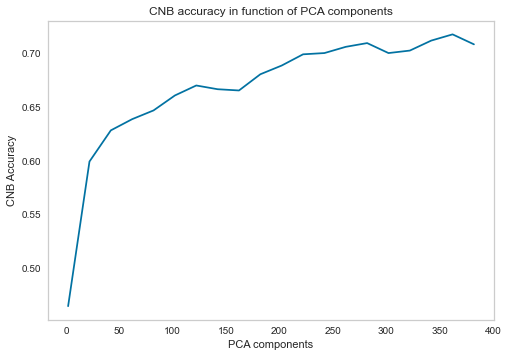

In [19]:
from sklearn.naive_bayes import ComplementNB

acc_CNB = []
for n in n_comp:
    CNB = ComplementNB(alpha = 1.0, class_prior = [0.13, 0.29, 0.29, 0.29])
    
    scaler = MinMaxScaler() # normalizes data to the range 0 to 1 thus removing the negative numbers.
    Train = scaler.fit_transform(pca_train[:,:n])
    
    CNB.fit(Train, y_train)
    
    Test = scaler.transform(pca_test[:,:n])
    y_predict = CNB.predict(Test)
    
    #y_predict = CNB.predict(pca_test[:,:n])
    
    cm2 = confusion_matrix(y_test, y_predict)
    acc2 = np.sum(np.diag(cm2))/np.sum(cm2)
    
    acc_CNB.append(acc2)

plt.figure()
plt.plot(n_comp, acc_CNB)
plt.grid()
plt.xlabel('PCA components')
plt.ylabel('CNB Accuracy')
plt.title('CNB accuracy in function of PCA components')
plt.show()

In [20]:
# we choose 322 PCA components as it gives the best accuracy for Multinomial Naive Bayes

ind = acc_CNB.index(max(acc_CNB))
print(n_comp[ind])

cb = ComplementNB(alpha = 1.0, class_prior = [0.13, 0.29, 0.29, 0.29])

scaler = MinMaxScaler() # normalizes data to the range 0 to 1 thus removing the negative numbers.
Train = scaler.fit_transform(pca_train[:,:n_comp[ind]])
    
cb.fit(Train, y_train)

Test = scaler.transform(pca_test[:,:n_comp[ind]])
y_pred = cb.predict(Test)
    
conf_pred = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division =0)
rep2 = classification_report(y_test, y_pred, output_dict=True, zero_division = 0)
print(report)

acc = rep2['accuracy']
pr = rep2['weighted avg']['precision']
rec = rep2['weighted avg']['recall']
f1 = rep2['weighted avg']['f1-score']

# Weighted avg Specificity ?
p = [0.13, 0.29, 0.29, 0.29]
spec = 0
for i in range(4):
    conf_i = conf_bin(conf_pred, i)
    tp = conf_i[0,0]
    fn = conf_i[0,1]
    tn = conf_i[1,1]
    fp = conf_i[1,0]
    spec += p[i]*(tn/(tn + fp))
print("weighted specificity = ", spec)

362
              precision    recall  f1-score   support

           0       0.69      0.69      0.69       114
           1       0.63      0.91      0.74       259
           2       0.84      0.92      0.88       236
           3       0.76      0.35      0.47       252

    accuracy                           0.72       861
   macro avg       0.73      0.72      0.70       861
weighted avg       0.73      0.72      0.69       861

weighted specificity =  0.8945737754117243


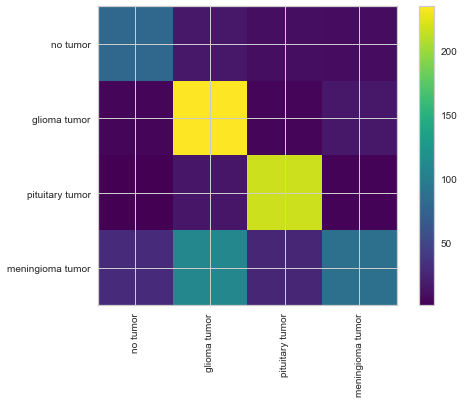

In [21]:
columns = ['no tumor', 'glioma tumor', 'pituitary tumor', 'meningioma tumor']

plt.xticks(range(len(columns)),columns,rotation=90)
plt.yticks(range(len(columns)),columns)
im = plt.imshow(conf_pred, cmap='viridis',interpolation="nearest")
plt.colorbar(im)

plt.show(im)

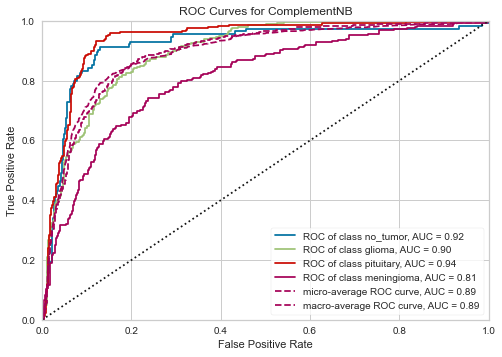

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for ComplementNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={0: 'no_tumor', 1: 'glioma', 2: 'pituitary', 3: 'meningioma'},
       estimator=ComplementNB(class_prior=[0.13, 0.29, 0.29, 0.29]))

In [22]:
plot_ROC_curve(cb, Train, y_train, Test, y_test)

In [23]:
# updating buffer
PCA_comp.append(n_comp[ind])
Acc.append(acc)
Pr.append(pr)
Rec.append(rec)
Spec.append(spec)
F1.append(f1)
AUC.append(0.89)

The cross validation shows similar global accuracy than precedently.

### Bernoulli Naive Bayes

BernoulliNB implements the naive Bayes training and classification algorithms for data that is distributed according to multivariate Bernoulli distributions; i.e., there may be multiple features but each one is assumed to be a binary-valued (Bernoulli, boolean) variable. Therefore, this class requires samples to be represented as binary-valued feature vectors; if handed any other kind of data, a BernoulliNB instance may binarize its input (depending on the binarize parameter).

The decision rule for Bernoulli naive Bayes is based on:

$$P\left(x_i \mid y\right) = P\left(x_i = 1 \mid y\right)x_i+\left(1-P\left(x_i=1\mid y\right)\right) \left(1-x_i\right)$$

which differs from multinomial NB’s rule in that it explicitly penalizes the non-occurrence of a feature $i$ that is an indicator for class $y$, where the multinomial variant would simply ignore a non-occurring feature.

In the case of text classification, word occurrence vectors (rather than word count vectors) may be used to train and use this classifier. BernoulliNB might perform better on some datasets, especially those with shorter documents. It is advisable to evaluate both models, if time permits.

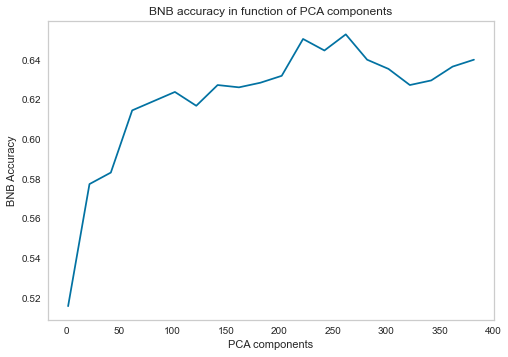

In [24]:
from sklearn.naive_bayes import BernoulliNB

acc_BNB = []
for n in n_comp:
    BNB = BernoulliNB(alpha = 1.0, class_prior = [0.13, 0.29, 0.29, 0.29])    
    BNB.fit(pca_train[:,:n], y_train)
    
    y_predict = BNB.predict(pca_test[:,:n])
    
    cm4 = confusion_matrix(y_test, y_predict)
    acc4 = np.sum(np.diag(cm4))/np.sum(cm4)
    
    acc_BNB.append(acc4)

plt.figure()
plt.plot(n_comp, acc_BNB)
plt.grid()
plt.xlabel('PCA components')
plt.ylabel('BNB Accuracy')
plt.title('BNB accuracy in function of PCA components')
plt.show()

In [25]:
# we choose 182 PCA components as it gives the best accuracy for Multinomial Naive Bayes

ind = acc_BNB.index(max(acc_BNB))
print(n_comp[ind])

bb = BernoulliNB(alpha = 1.0, class_prior = [0.13, 0.29, 0.29, 0.29])

scaler = MinMaxScaler() # normalizes data to the range 0 to 1 thus removing the negative numbers.
Train = pca_train[:,:n_comp[ind]]
    
bb.fit(Train, y_train)

Test = pca_test[:,:n_comp[ind]]
y_pred = bb.predict(Test)
    
conf_pred = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, zero_division =0)
rep2 = classification_report(y_test, y_pred, output_dict=True, zero_division = 0)
print(report)

acc = rep2['accuracy']
pr = rep2['weighted avg']['precision']
rec = rep2['weighted avg']['recall']
f1 = rep2['weighted avg']['f1-score']

# Weighted avg Specificity ?
p = [0.13, 0.29, 0.29, 0.29]
spec = 0
for i in range(4):
    conf_i = conf_bin(conf_pred, i)
    tp = conf_i[0,0]
    fn = conf_i[0,1]
    tn = conf_i[1,1]
    fp = conf_i[1,0]
    spec += p[i]*(tn/(tn + fp))
print("weighted specificity = ", spec)

262
              precision    recall  f1-score   support

           0       0.66      0.40      0.50       114
           1       0.66      0.70      0.68       259
           2       0.74      0.83      0.78       236
           3       0.56      0.55      0.55       252

    accuracy                           0.65       861
   macro avg       0.65      0.62      0.63       861
weighted avg       0.65      0.65      0.65       861

weighted specificity =  0.865186030714219


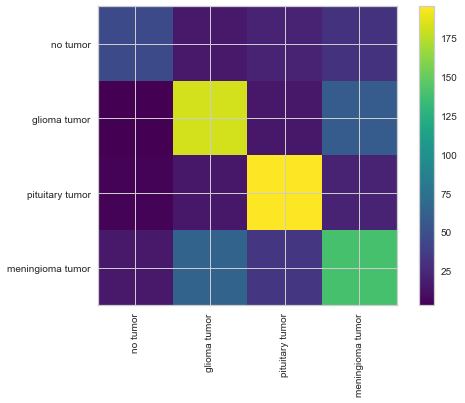

In [26]:
columns = ['no tumor', 'glioma tumor', 'pituitary tumor', 'meningioma tumor']

plt.xticks(range(len(columns)),columns,rotation=90)
plt.yticks(range(len(columns)),columns)
im = plt.imshow(conf_pred, cmap='viridis',interpolation="nearest")
plt.colorbar(im)

plt.show(im)

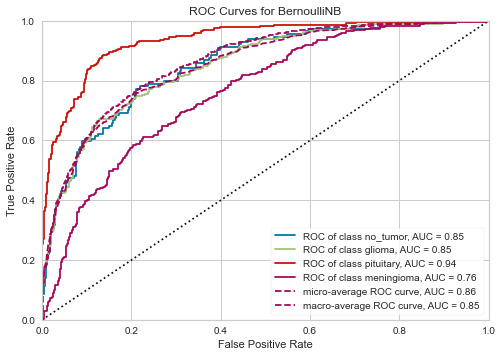

ROCAUC(ax=<AxesSubplot:title={'center':'ROC Curves for BernoulliNB'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
       encoder={0: 'no_tumor', 1: 'glioma', 2: 'pituitary', 3: 'meningioma'},
       estimator=BernoulliNB(class_prior=[0.13, 0.29, 0.29, 0.29]))

In [27]:
plot_ROC_curve(bb, Train, y_train, Test, y_test)

In [28]:
# updating buffer
PCA_comp.append(n_comp[ind])
Acc.append(acc)
Pr.append(pr)
Rec.append(rec)
Spec.append(spec)
F1.append(f1)
AUC.append(0.82)

### Categorical Naive Bayes

CategoricalNB implements the categorical naive Bayes algorithm for categorically distributed data. It assumes that each feature, which is described by the index , has its own categorical distribution.

For each feature $i$ in the training set $X$, CategoricalNB estimates a categorical distribution for each feature i of X conditioned on the class y. The index set of the samples is defined as $J = \left{1,\dots,m\right}$, with $m$ as the number of samples.

The probability of category  in feature  given class  is estimated as:

$$P\left(x_i=t\mid y=c; \alpha\right)=\frac{N_{tic}+\alpha}{N_c + \alpha n_i},$$

where $N_{tic} = \left|\{ j\in J\mid x_{ij} = t,y_j=c\}\right|$ is the number of times category $t$ appears in the samples $x_i$, which belong to class $c$, $N_c=\left|\{j\in J\mid y_j=c\}\right|$ is the number of samples with class c, $\alpha$ is a smoothing parameter and $n_i$ is the number of available categories of feature $i$.

CategoricalNB assumes that the sample matrix $X$ is encoded (for instance with the help of OrdinalEncoder) such that all categories for each feature  are represented with numbers $0,\dots,n_i-1$ where $n_i$ is the number of available categories of feature $i$.

In [29]:
#from sklearn.naive_bayes import CategoricalNB

#acc_CatNB = []
#for n in n_comp:
#    CatNB = CategoricalNB(alpha = 1.0, class_prior = [0.25, 0.25, 0.25, 0.25])    
    
#    scaler = MinMaxScaler() # normalizes data to the range 0 to 1 thus removing the negative numbers.
#    Train = scaler.fit_transform(pca_train[:,:n])
    
#    CatNB.fit(Train, y_train)
    
    #Test = scaler.fit_transform(pca_test[:,:n])
#    y_predict = CatNB.predict(abs(pca_test[:,:n]))
    
#    cm5 = confusion_matrix(y_test, y_predict)
#    acc5 = np.sum(np.diag(cm5))/np.sum(cm5)
    
#    acc_CatNB.append(acc5)

#plt.figure()
#plt.plot(n_comp, acc_CatNB)
#plt.grid()
#plt.xlabel('PCA components')
#plt.ylabel('CatNB Accuracy')
#plt.title('CatNB accuracy in function of PCA components')
#plt.show()

## Resume

In [30]:
data = {'Classifiers':  classifiers,
        'PCA components': PCA_comp,
        'Accuracy' : Acc,
        'Weighted Precision': Pr,
        'Weighted Recall' : Rec,
        'Weighted Specificity' : Spec,
        'Weighted F1 Score' : F1,
        'Weighted AUC' : AUC
        }

resume = pd.DataFrame(data)

print(resume)

   Classifiers  PCA components  Accuracy  Weighted Precision  Weighted Recall  \
0  Multinomial             302  0.671312            0.579125         0.671312   
1     Gaussian              22  0.587689            0.589949         0.587689   
2   Complement             362  0.717770            0.733123         0.717770   
3    Bernoulli             262  0.652729            0.649846         0.652729   

   Weighted Specificity  Weighted F1 Score  Weighted AUC  
0              0.865471           0.620529          0.83  
1              0.845517           0.556723          0.81  
2              0.894574           0.694816          0.89  
3              0.865186           0.646367          0.82  
